In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model, image_dataset_from_directory
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, RandomContrast, RandomRotation, RandomZoom, RandomFlip

In [2]:
data_dir = pathlib.Path(r"C:\Users\DELL\Downloads\NM PROJECT\dataset")
data = image_dataset_from_directory(data_dir, seed = 123, image_size=(224, 224))
class_names = data.class_names

Found 4217 files belonging to 4 classes.


2023-01-18 21:18:54.944939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:18:55.063260: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:18:55.064060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-18 21:18:55.067898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

2023-01-18 21:18:57.930019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<AxesSubplot:>

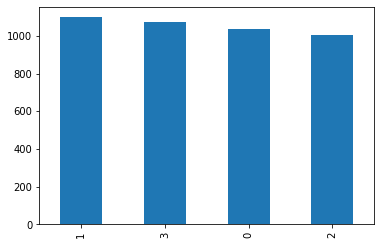

In [3]:
labels = np.concatenate([y for x,y in data], axis=0)
values = pd.value_counts(labels)
values.plot(kind='bar')

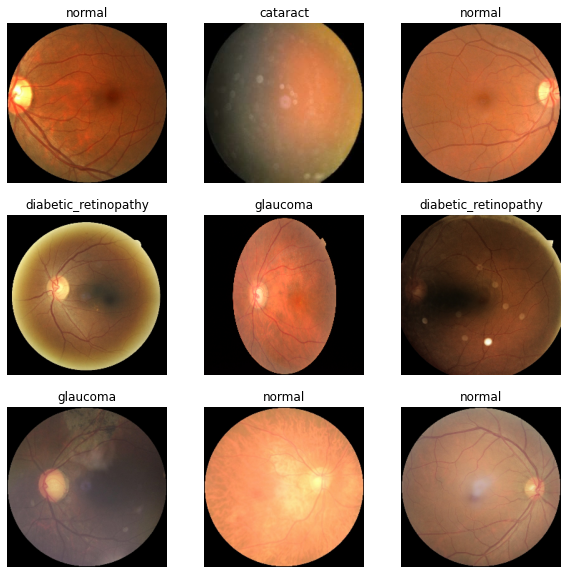

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")

In [5]:
data = data.map(lambda x, y: (x/255, y))
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [6]:
test_iter = test.as_numpy_iterator()
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break
y_test = test_set['labels']

In [7]:
def evaluate_model(model):
    model.evaluate(test)
    y_pred = np.argmax(model.predict(test_set['images']), 1)
    print(classification_report(y_test, y_pred, target_names = class_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sn.heatmap(cm, annot=True)
    plt.xticks(np.arange(4)+.5, class_names, rotation=90)
    plt.yticks(np.arange(4)+.5, class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

In [8]:
model = Sequential([
        Conv2D(64, (3,3), activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        Conv2D(64, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Conv2D(128, (3,3), padding='same', activation = 'relu'),
        Conv2D(128, (3,3),padding='same', activation = 'relu'),
        Conv2D(128, (3,3), activation = 'relu',padding='same'),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dense(4, activation='softmax')
    ])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     1

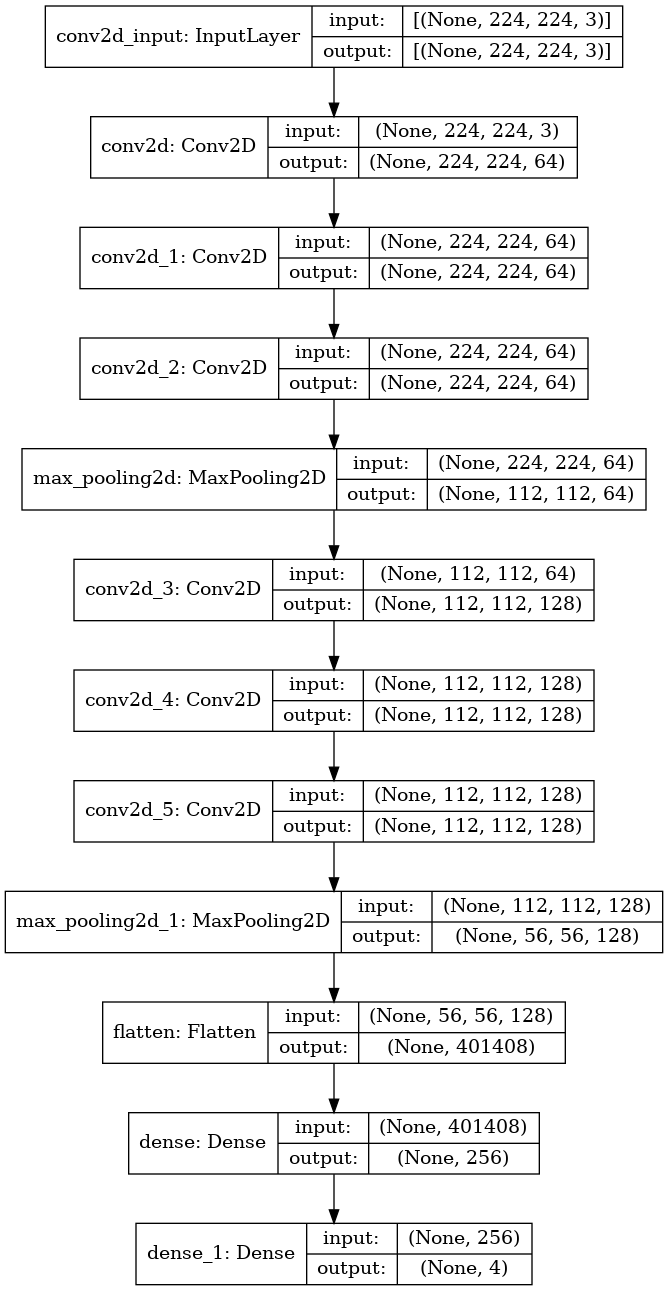

In [10]:
plot_model(model, to_file='simple-cnn.png', show_shapes=True)

In [11]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10


2023-01-18 21:20:03.490321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 50s 421ms/step - loss: 1.0477 - accuracy: 0.5027 - val_loss: 0.8308 - val_accuracy: 0.6034
Epoch 2/10
93/93 [==============================] - 40s 418ms/step - loss: 0.7380 - accuracy: 0.6683 - val_loss: 0.6126 - val_accuracy: 0.7224
Epoch 3/10
93/93 [==============================] - 40s 418ms/step - loss: 0.5956 - accuracy: 0.7288 - val_loss: 0.5638 - val_accuracy: 0.7596
Epoch 4/10
93/93 [==============================] - 40s 416ms/step - loss: 0.5267 - accuracy: 0.7789 - val_loss: 0.5518 - val_accuracy: 0.7800
Epoch 5/10
93/93 [==============================] - 41s 421ms/step - loss: 0.4983 - accuracy: 0.7893 - val_loss: 0.5242 - val_accuracy: 0.7608
Epoch 6/10
93/93 [==============================] - 41s 423ms/step - loss: 0.4449 - accuracy: 0.8142 - val_loss: 0.5287 - val_accuracy: 0.7584
Epoch 7/10
93/93 [==============================] - 41s 422ms/step - loss: 0.4073 - accuracy: 0.8280 - val_loss: 0.5150 - val_accuracy: 0.7933
Epoch 8/10

In [12]:
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

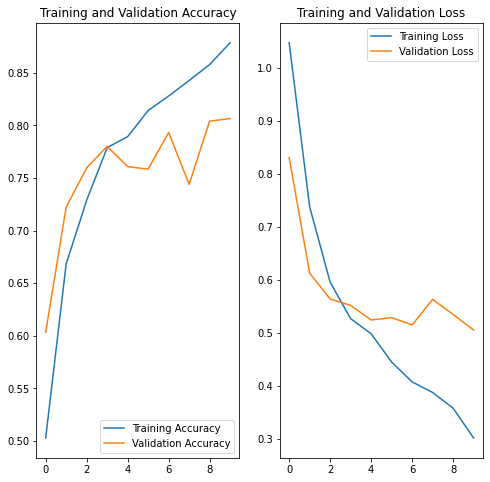

In [13]:
plot_performance(10, history)

13/13 [==============================] - 22s 178ms/step - loss: 0.6483 - accuracy: 0.7897
                      precision    recall  f1-score   support

            cataract       0.62      0.64      0.63        91
diabetic_retinopathy       1.00      1.00      1.00       109
            glaucoma       0.67      0.50      0.57       103
              normal       0.77      0.94      0.85       106

            accuracy                           0.78       409
           macro avg       0.76      0.77      0.76       409
        weighted avg       0.77      0.78      0.77       409



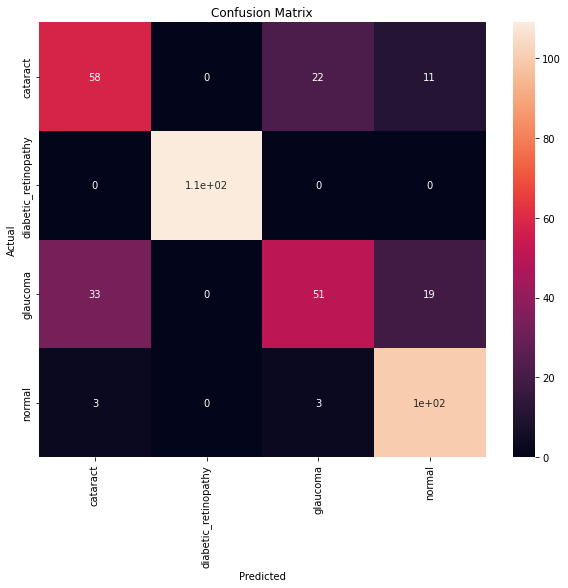

In [14]:
evaluate_model(model)

In [15]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

In [16]:
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage.transform import resize

def predict_image(image_path):
    img = imread(image_path)
    img = resize(img, (224,224))

    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    prediction = np.argmax(preds)
    pct = np.max(preds)
    if prediction == 0:
        print('Cataract')
    elif prediction == 1:
        print('Diabetic retinopathy')
    elif prediction == 2:
        print('Glaucoma')
    else:
        print('Normal')
    print(pct)
    return img

In [17]:
def explain_prediction(image_path):
    img = predict_image(image_path)
    explainer = lime_image.LimeImageExplainer(random_state=12)
    explanation = explainer.explain_instance(
             img[0].astype('double'), 
             model.predict
    )
    from skimage.segmentation import mark_boundaries

    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

Diabetic retinopathy
0.99703634


  0%|          | 0/1000 [00:00<?, ?it/s]

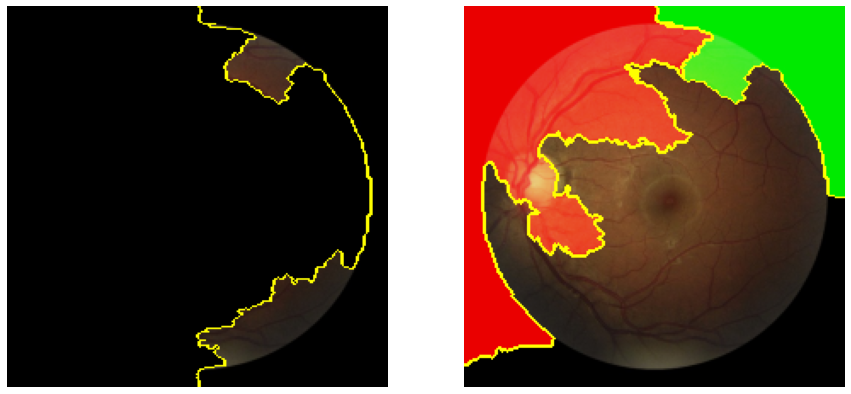

In [18]:
explain_prediction(r"C:\Users\DELL\Downloads\NM PROJECT\dataset\diabetic_retinopathy\1196_left.jpeg")

Glaucoma
0.82309645


  0%|          | 0/1000 [00:00<?, ?it/s]

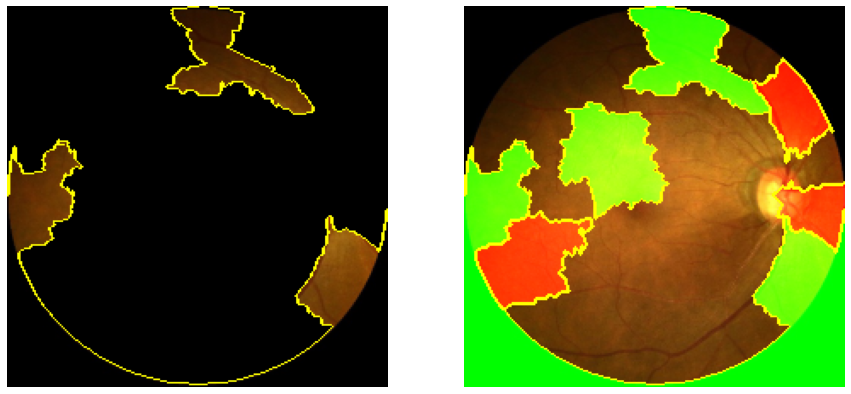

In [19]:
explain_prediction(r"C:\Users\DELL\Downloads\NM PROJECT\dataset\glaucoma\1389_right.jpg")

Cataract
0.55044264


  0%|          | 0/1000 [00:00<?, ?it/s]

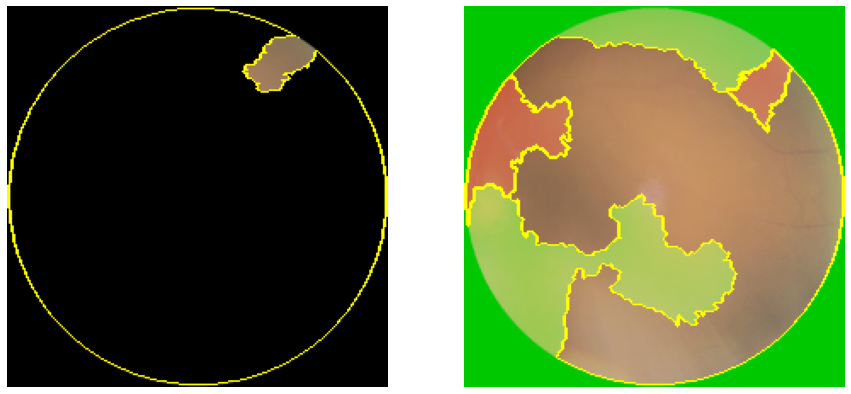

In [20]:
explain_prediction(r"C:\Users\DELL\Downloads\NM PROJECT\dataset\cataract\103_left.jpg")

In [23]:
from tensorflow.keras.applications import ResNet50V2


base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [24]:
history = model.fit(train, validation_data=val, epochs = 10)

Epoch 1/10
93/93 [==============================] - 42s 427ms/step - loss: 1.4880 - accuracy: 0.3330 - val_loss: 1.2884 - val_accuracy: 0.3377
Epoch 2/10
93/93 [==============================] - 41s 422ms/step - loss: 1.2061 - accuracy: 0.4422 - val_loss: 1.2070 - val_accuracy: 0.4303
Epoch 3/10
93/93 [==============================] - 41s 421ms/step - loss: 1.1080 - accuracy: 0.4906 - val_loss: 1.2600 - val_accuracy: 0.4291
Epoch 4/10
93/93 [==============================] - 42s 427ms/step - loss: 1.0396 - accuracy: 0.5235 - val_loss: 1.0169 - val_accuracy: 0.5481
Epoch 5/10
93/93 [==============================] - 41s 426ms/step - loss: 1.0218 - accuracy: 0.5235 - val_loss: 1.0188 - val_accuracy: 0.5349
Epoch 6/10
93/93 [==============================] - 41s 424ms/step - loss: 0.9241 - accuracy: 0.5719 - val_loss: 0.8953 - val_accuracy: 0.6070
Epoch 7/10
93/93 [==============================] - 40s 415ms/step - loss: 0.8572 - accuracy: 0.5998 - val_loss: 0.7871 - val_accuracy: 0.6346

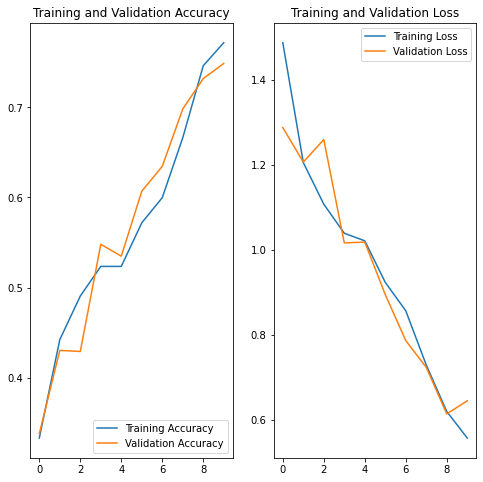

In [25]:
plot_performance(10, history)

13/13 [==============================] - 20s 90ms/step - loss: 0.5973 - accuracy: 0.7653
                      precision    recall  f1-score   support

            cataract       0.84      0.80      0.82        91
diabetic_retinopathy       0.94      0.81      0.87       109
            glaucoma       0.72      0.50      0.59       103
              normal       0.62      0.91      0.73       106

            accuracy                           0.76       409
           macro avg       0.78      0.76      0.75       409
        weighted avg       0.78      0.76      0.75       409



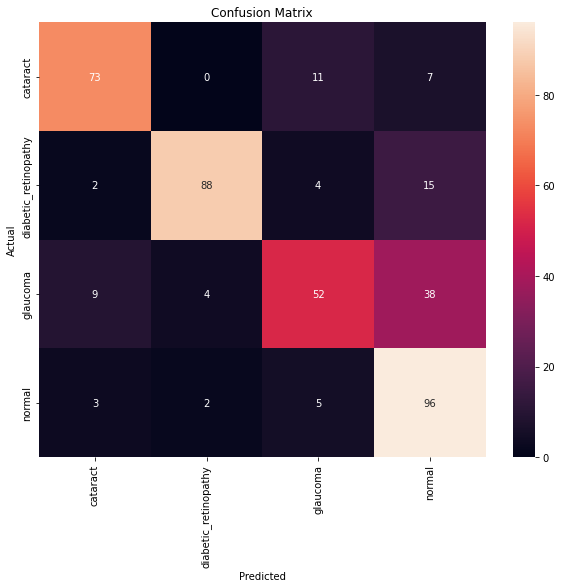

In [26]:
evaluate_model(model)

In [28]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 8,217,796
Trainable params: 7,068,356
Non-trainable params: 1,149,440
____________________________________

In [29]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
93/93 [==============================] - 49s 418ms/step - loss: 1.2556 - accuracy: 0.7762 - val_loss: 1.6070 - val_accuracy: 0.7115
Epoch 2/10
93/93 [==============================] - 39s 403ms/step - loss: 0.3498 - accuracy: 0.8777 - val_loss: 0.4894 - val_accuracy: 0.8486
Epoch 3/10
93/93 [==============================] - 39s 402ms/step - loss: 0.2238 - accuracy: 0.9106 - val_loss: 0.4264 - val_accuracy: 0.8654
Epoch 4/10
93/93 [==============================] - 39s 400ms/step - loss: 0.1948 - accuracy: 0.9264 - val_loss: 0.2702 - val_accuracy: 0.9026
Epoch 5/10
93/93 [==============================] - 39s 404ms/step - loss: 0.1483 - accuracy: 0.9422 - val_loss: 1.3360 - val_accuracy: 0.7344
Epoch 6/10
93/93 [==============================] - 39s 404ms/step - loss: 0.1280 - accuracy: 0.9513 - val_loss: 0.1970 - val_accuracy: 0.9375
Epoch 7/10
93/93 [==============================] - 40s 400ms/step - loss: 0.0937 - accuracy: 0.9664 - val_loss: 0.2290 - val_accuracy: 0.9291

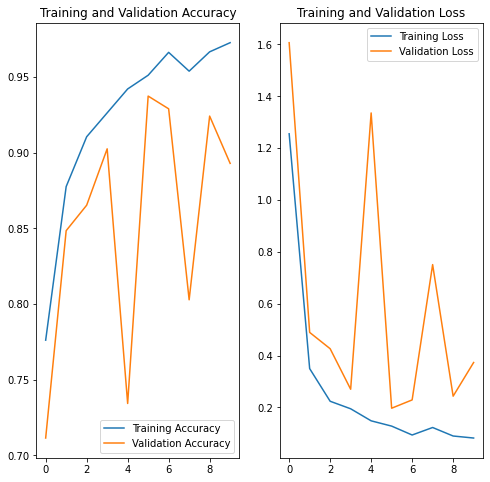

In [30]:
plot_performance(10, history)

13/13 [==============================] - 20s 132ms/step - loss: 0.4201 - accuracy: 0.8851
                      precision    recall  f1-score   support

            cataract       0.99      0.95      0.97        91
diabetic_retinopathy       0.96      1.00      0.98       109
            glaucoma       0.72      0.94      0.82       103
              normal       0.96      0.68      0.80       106

            accuracy                           0.89       409
           macro avg       0.91      0.89      0.89       409
        weighted avg       0.91      0.89      0.89       409



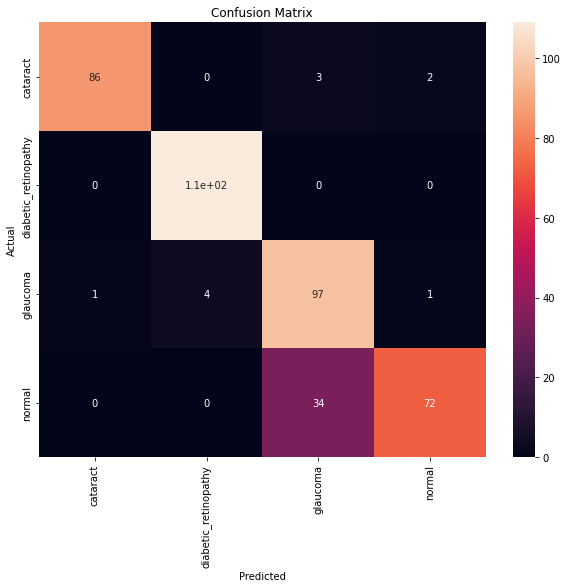

In [31]:
evaluate_model(model)

In [ ]:
from tensorflow.keras.applications import Xception


base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 2052      
Total params: 4,712,615
Trainable params: 660,484
Non-trainable params: 4,052,131
_________________________________________________________________


In [36]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
93/93 [==============================] - 43s 390ms/step - loss: 2.4876 - accuracy: 0.3589 - val_loss: 2.2447 - val_accuracy: 0.2380
Epoch 2/10
93/93 [==============================] - 37s 377ms/step - loss: 1.9223 - accuracy: 0.3861 - val_loss: 2.9222 - val_accuracy: 0.2344
Epoch 3/10
93/93 [==============================] - 36s 379ms/step - loss: 1.6540 - accuracy: 0.4160 - val_loss: 3.6583 - val_accuracy: 0.2356
Epoch 4/10
93/93 [==============================] - 36s 375ms/step - loss: 1.4458 - accuracy: 0.4291 - val_loss: 3.4549 - val_accuracy: 0.2332
Epoch 5/10
93/93 [==============================] - 37s 377ms/step - loss: 1.3091 - accuracy: 0.4395 - val_loss: 2.6582 - val_accuracy: 0.2356
Epoch 6/10
93/93 [==============================] - 37s 380ms/step - loss: 1.2268 - accuracy: 0.4600 - val_loss: 1.6377 - val_accuracy: 0.2993
Epoch 7/10
93/93 [==============================] - 38s 385ms/step - loss: 1.1926 - accuracy: 0.4640 - val_loss: 1.4443 - val_accuracy: 0.3606

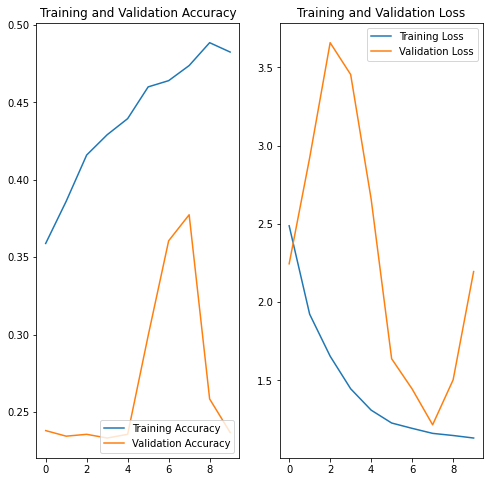

In [37]:
plot_performance(10, history)

13/13 [==============================] - 20s 99ms/step - loss: 2.1241 - accuracy: 0.2543


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

            cataract       0.22      1.00      0.37        91
diabetic_retinopathy       1.00      0.02      0.04       109
            glaucoma       0.00      0.00      0.00       103
              normal       0.00      0.00      0.00       106

            accuracy                           0.23       409
           macro avg       0.31      0.25      0.10       409
        weighted avg       0.32      0.23      0.09       409



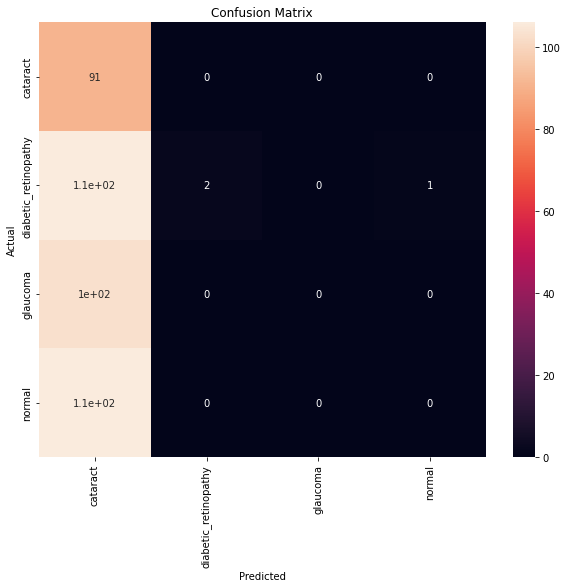

In [38]:
evaluate_model(model)

In [41]:
from keras.applications.vgg19 import VGG19

vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg19.layers:
    layer.trainable = False


model = Sequential([
    vgg19,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 516       
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
history = model.fit(train,validation_data=val,epochs = 10)

Epoch 1/10
93/93 [==============================] - 39s 385ms/step - loss: 0.8365 - accuracy: 0.6935 - val_loss: 0.5445 - val_accuracy: 0.7680
Epoch 2/10
93/93 [==============================] - 38s 385ms/step - loss: 0.4144 - accuracy: 0.8263 - val_loss: 0.4675 - val_accuracy: 0.8125
Epoch 3/10
93/93 [==============================] - 37s 385ms/step - loss: 0.4001 - accuracy: 0.8364 - val_loss: 0.3040 - val_accuracy: 0.8822
Epoch 4/10
93/93 [==============================] - 37s 386ms/step - loss: 0.3393 - accuracy: 0.8619 - val_loss: 0.3689 - val_accuracy: 0.8618
Epoch 5/10
93/93 [==============================] - 37s 380ms/step - loss: 0.3197 - accuracy: 0.8767 - val_loss: 0.2993 - val_accuracy: 0.8714
Epoch 6/10
93/93 [==============================] - 37s 385ms/step - loss: 0.3088 - accuracy: 0.8733 - val_loss: 0.2925 - val_accuracy: 0.8810
Epoch 7/10
93/93 [==============================] - 36s 377ms/step - loss: 0.2895 - accuracy: 0.8827 - val_loss: 0.3825 - val_accuracy: 0.8438

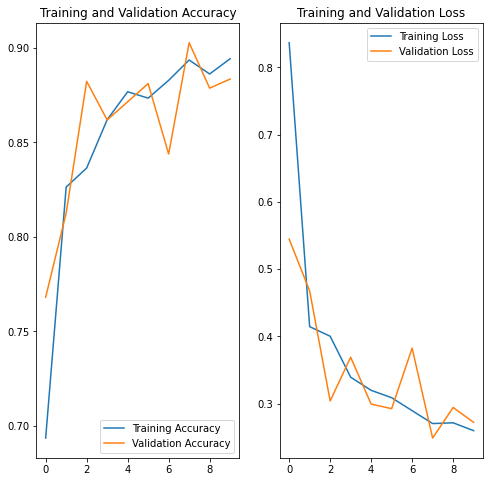

In [44]:
plot_performance(10, history)

13/13 [==============================] - 21s 205ms/step - loss: 0.2926 - accuracy: 0.8802
                      precision    recall  f1-score   support

            cataract       0.88      0.93      0.90        91
diabetic_retinopathy       0.97      1.00      0.99       109
            glaucoma       0.90      0.69      0.78       103
              normal       0.83      0.94      0.88       106

            accuracy                           0.89       409
           macro avg       0.89      0.89      0.89       409
        weighted avg       0.89      0.89      0.89       409



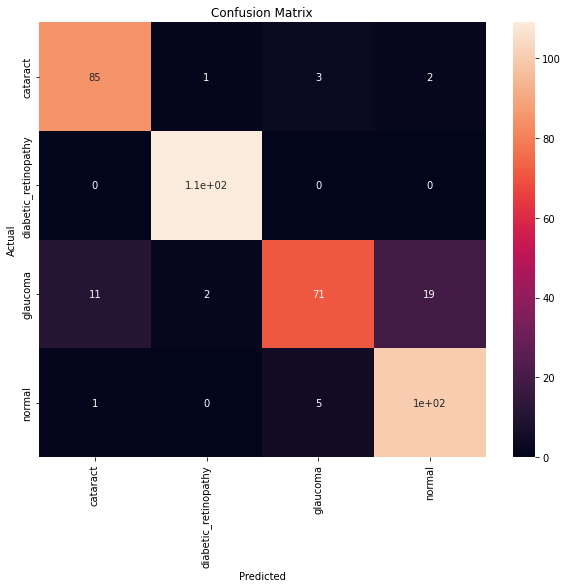

In [45]:
evaluate_model(model)

In [ ]:
model.save("vgg19_model.h5")


In [ ]:
from flask import Flask, render_template, request
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("vgg19_model.h5")

app = Flask(__name__)


@app.route('/')
def index():
    return render_template('index.html')

@app.route('/home')
def home():
    return render_template('index.html')

@app.route('/inp')
def inp():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Get the uploaded image file
        f = request.files['image']
        basepath = os.path.dirname(__file__)
        filepath = os.path.join(basepath, 'uploads', f.filename)
        f.save(filepath)

        # Preprocess the image
        img = image.load_img(filepath, target_size=(224, 224, 3))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data = preprocess_input(x)

        # Make prediction
        prediction = np.argmax(model.predict(img_data), axis=1)
        index = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
        result = str(index[prediction[0]])
        print(result)

        return render_template('output.html', prediction=result)


if __name__ == '__main__':
    app.run()
